In [1]:
import pandas as pd
import numpy as np
import openpyxl
from openpyxl.styles import PatternFill, Font, Border, Side, Alignment
from openpyxl.formatting.rule import ColorScaleRule, FormulaRule, Rule
from openpyxl.styles.differential import DifferentialStyle
from openpyxl.worksheet.datavalidation import DataValidation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest # For anomaly detection
from sklearn.preprocessing import StandardScaler # For scaling data for ML

In [3]:
try:
    df_q1 = pd.read_excel('quarter1.xlsx', sheet_name='Sheet1')
    df_q2 = pd.read_excel('quarter2.xlsx', sheet_name='Sheet1')
    print("Excel files loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure 'quarter1.xlsx' and 'quarter2.xlsx' are in the same directory as your script.")
    exit() # Exit if files are not found

# Display first few rows to understand structure
print("\nQ1 Data Head:")
print(df_q1.head())
print("\nQ2 Data Head:")
print(df_q2.head())

Excel files loaded successfully!

Q1 Data Head:
          Item  Department     Category  Revenue  Expenses  Units Sold  \
0   Client 000  Operations     Supplies    64268     20675         312   
1   Region 001     Finance  Electronics    97939     26938         813   
2  Product 002     Finance     Supplies    28141     26664         193   
3   Client 003       Sales     Supplies    90356      4636         395   
4   Client 004  Operations  Electronics    81910     23080         673   

   Customer Count  Profit  
0             217   43593  
1             454   71001  
2             178    1477  
3             493   85720  
4             170   58830  

Q2 Data Head:
          Item  Department     Category       Revenue      Expenses  \
0   Client 000  Operations     Supplies  59180.819658  24440.694369   
1   Region 001     Finance  Electronics  83853.672226  31746.313632   
2  Product 002     Finance     Supplies  33521.665635  26352.955577   
3   Client 003       Sales     Supplies 

In [5]:
# Assuming 'Item' is the common key and 'Value' is the numeric column to compare
# Adjust column names based on your actual data
key_column = 'Item'
value_column = 'Profit' # Or 'Sales', 'Amount', etc.

# Rename value columns to differentiate after merge
df_q1_renamed = df_q1.rename(columns={value_column: 'Q1_Value'})
df_q2_renamed = df_q2.rename(columns={value_column: 'Q2_Value'})

# Merge dataframes on the key column
# use 'outer' to include items present in only one quarter
df_merged = pd.merge(df_q1_renamed, df_q2_renamed, on=key_column, how='outer', suffixes=('_Q1', '_Q2'))

# Fill NaN values (for items only in one quarter) with 0 for calculation
df_merged['Q1_Value'] = df_merged['Q1_Value'].fillna(0)
df_merged['Q2_Value'] = df_merged['Q2_Value'].fillna(0)

print("\nMerged Data Head:")
print(df_merged.head())


Merged Data Head:
         Item Department_Q1  Category_Q1  Revenue_Q1  Expenses_Q1  \
0  Client 000    Operations     Supplies     64268.0      20675.0   
1  Client 003         Sales     Supplies     90356.0       4636.0   
2  Client 004    Operations  Electronics     81910.0      23080.0   
3  Client 008         Sales    Logistics     65820.0       3854.0   
4  Client 010       Finance   Consulting     91734.0      10392.0   

   Units Sold_Q1  Customer Count_Q1  Q1_Value Department_Q2  Category_Q2  \
0          312.0              217.0   43593.0    Operations     Supplies   
1          395.0              493.0   85720.0         Sales     Supplies   
2          673.0              170.0   58830.0    Operations  Electronics   
3          946.0              286.0   61966.0         Sales    Logistics   
4          303.0              413.0   81342.0       Finance   Consulting   

     Revenue_Q2   Expenses_Q2  Units Sold_Q2  Customer Count_Q2      Q2_Value  
0  59180.819658  24440.694369

In [6]:
df_merged['Absolute_Variance'] = df_merged['Q2_Value'] - df_merged['Q1_Value']

# Calculate Percentage Variance, handling division by zero
df_merged['Percentage_Variance'] = df_merged.apply(
    lambda row: (row['Absolute_Variance'] / row['Q1_Value']) * 100 if row['Q1_Value'] != 0 else np.nan,
    axis=1
)

# Replace infinite values (if Q1_Value was 0 and Q2_Value non-zero) or NaN from division with a meaningful string
df_merged['Percentage_Variance'] = df_merged['Percentage_Variance'].replace([np.inf, -np.inf], np.nan)
df_merged['Percentage_Variance'] = df_merged['Percentage_Variance'].fillna('N/A for Q1=0')

# Optional: Add a 'Variance_Category' column for easier grouping/filtering
def categorize_variance(pct_var):
    if isinstance(pct_var, (int, float)):
        if abs(pct_var) >= 20: # High variance threshold (e.g., 20%)
            return 'High Variance'
        elif abs(pct_var) >= 5: # Medium variance threshold
            return 'Medium Variance'
        elif abs(pct_var) > 0:
            return 'Low Variance'
    return 'No Change / N/A'

df_merged['Variance_Category'] = df_merged['Percentage_Variance'].apply(categorize_variance)

print("\nData with Variances and Categories:")
print(df_merged.head())


Data with Variances and Categories:
         Item Department_Q1  Category_Q1  Revenue_Q1  Expenses_Q1  \
0  Client 000    Operations     Supplies     64268.0      20675.0   
1  Client 003         Sales     Supplies     90356.0       4636.0   
2  Client 004    Operations  Electronics     81910.0      23080.0   
3  Client 008         Sales    Logistics     65820.0       3854.0   
4  Client 010       Finance   Consulting     91734.0      10392.0   

   Units Sold_Q1  Customer Count_Q1  Q1_Value Department_Q2  Category_Q2  \
0          312.0              217.0   43593.0    Operations     Supplies   
1          395.0              493.0   85720.0         Sales     Supplies   
2          673.0              170.0   58830.0    Operations  Electronics   
3          946.0              286.0   61966.0         Sales    Logistics   
4          303.0              413.0   81342.0       Finance   Consulting   

     Revenue_Q2   Expenses_Q2  Units Sold_Q2  Customer Count_Q2      Q2_Value  \
0  59180.8

In [7]:
# Identify numerical columns for anomaly detection
# It's usually best to apply anomaly detection on the variance itself or on the original values
# For this example, let's detect anomalies in 'Absolute_Variance'
numeric_variance_data = df_merged[df_merged['Absolute_Variance'].apply(lambda x: isinstance(x, (int, float)))]['Absolute_Variance'].values.reshape(-1, 1)

if len(numeric_variance_data) > 0:
    # Scale data for better ML performance (especially with distance-based algorithms)
    scaler = StandardScaler()
    scaled_variance = scaler.fit_transform(numeric_variance_data)

    # Initialize Isolation Forest model
    # contamination: The proportion of outliers in the data set. Adjust this based on your expectation.
    # A common range is 0.01 to 0.1 (1% to 10% outliers).
    iso_forest = IsolationForest(contamination=0.05, random_state=42) # 5% of data points are outliers

    # Fit the model and predict anomalies
    # -1 for outliers, 1 for inliers
    df_merged['Is_Anomaly'] = 0 # Initialize with 0
    anomaly_indices = iso_forest.fit_predict(scaled_variance)
    
    # Map back to original dataframe, handling rows that were not numeric for variance
    original_indices_for_numeric_variance = df_merged[df_merged['Absolute_Variance'].apply(lambda x: isinstance(x, (int, float)))].index
    
    df_merged.loc[original_indices_for_numeric_variance, 'Is_Anomaly'] = anomaly_indices
    df_merged['Is_Anomaly'] = df_merged['Is_Anomaly'].map({-1: True, 1: False}) # True for anomaly, False for normal

    print("\nAnomalies Detected:")
    print(df_merged[df_merged['Is_Anomaly'] == True])
else:
    print("\nNot enough numeric variance data to perform anomaly detection.")
    df_merged['Is_Anomaly'] = False # Default to no anomalies if no numeric data


Anomalies Detected:
             Item Department_Q1  Category_Q1  Revenue_Q1  Expenses_Q1  \
17  New Item Q2 5           NaN          NaN         NaN          NaN   
30     Region 014     Marketing  Electronics     74044.0       7931.0   
33     Region 018     Marketing     Software     79163.0       5327.0   

    Units Sold_Q1  Customer Count_Q1  Q1_Value Department_Q2 Category_Q2  \
17            NaN                NaN       0.0       Finance   Logistics   
30          209.0              204.0   66113.0           NaN         NaN   
33          708.0              185.0   73836.0           NaN         NaN   

    Revenue_Q2  Expenses_Q2  Units Sold_Q2  Customer Count_Q2  Q2_Value  \
17     34703.0      11337.0          377.0              168.0   60810.0   
30         NaN          NaN            NaN                NaN       0.0   
33         NaN          NaN            NaN                NaN       0.0   

    Absolute_Variance Percentage_Variance Variance_Category  Is_Anomaly  
17    

LLM for Interpretation (Conceptual):

Integrating an LLM directly into the generation of the Excel report is complex, but you could use an LLM to:

Generate descriptions for anomalies: Pass the df_merged[df_merged['Is_Anomaly'] == True] data (e.g., "Product A had a 150% increase in Q2 sales from Q1") to an LLM and ask it to generate potential reasons or follow-up questions.

Suggest further analysis: Based on variance categories, ask the LLM what kind of deeper dives might be needed (e.g., "For 'High Variance' items, what are common reasons for such large swings in financial data?").

This would typically be an additional Python script or interactive step, not directly embedded in the Excel generation itself.

In [12]:
# Create a new Excel workbook and select the active sheet
output_filename = 'Variance_Report_Python.xlsx'
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Variance Report"

# Write headers
headers = df_merged.columns.tolist()
ws.append(headers)

# Write data rows
for r_idx, row_data in df_merged.iterrows():
    ws.append(row_data.tolist())

# --- Apply Formatting ---

# 1. Header Formatting
header_font = Font(bold=True, color="FFFFFF")
header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
header_alignment = Alignment(horizontal="center", vertical="center")
header_border = Border(left=Side(style='thin'), right=Side(style='thin'),
                       top=Side(style='thin'), bottom=Side(style='thin'))

for col_idx in range(1, len(headers) + 1):
    cell = ws.cell(row=1, column=col_idx)
    cell.font = header_font
    cell.fill = header_fill
    cell.alignment = header_alignment
    cell.border = header_border

# 2. General Cell Formatting
# Auto-fit columns (approximate, adjust manually if needed for perfection)
for col in ws.columns:
    max_length = 0
    column = col[0].column_letter # Get the column name
    for cell in col:
        try: # Necessary to avoid error on empty cells
            if len(str(cell.value)) > max_length:
                max_length = len(str(cell.value))
        except:
            pass
    adjusted_width = (max_length + 2) * 1.2 # Add a little padding
    ws.column_dimensions[column].width = adjusted_width

# Set number format for value columns
for col_letter in ['B', 'C', 'D']: # Q1_Value, Q2_Value, Absolute_Variance
    for row_idx in range(2, ws.max_row + 1):
        ws[f'{col_letter}{row_idx}'].number_format = '#,##0.00' # Currency/Number format

# Set percentage format for Percentage_Variance column
pct_col_idx = headers.index('Percentage_Variance') + 1 # Get column number (1-indexed)
for row_idx in range(2, ws.max_row + 1):
    cell = ws.cell(row=row_idx, column=pct_col_idx)
    if isinstance(cell.value, (int, float)): # Only format if it's a number
        cell.number_format = '0.00%'
    else: # Center 'N/A' text
        cell.alignment = Alignment(horizontal="center")


In [17]:
# 3. Conditional Formatting for Variances

# Define styles for conditional formatting
red_fill = PatternFill(start_color="FFCCCC", end_color="FFCCCC", fill_type="solid") # Light Red
green_fill = PatternFill(start_color="CCFFCC", end_color="CCFFCC", fill_type="solid") # Light Green
orange_fill = PatternFill(start_color="FFD699", end_color="FFD699", fill_type="solid") # Light Orange
red_font = Font(color="990000") # Dark Red
green_font = Font(color="006600") # Dark Green

# Conditional formatting for Absolute_Variance (Column D assuming 'Absolute_Variance' is D)
absolute_var_col_letter = chr(ord('A') + headers.index('Absolute_Variance'))
abs_var_range = f"{absolute_var_col_letter}2:{absolute_var_col_letter}{ws.max_row}"

# Highlight significant positive variance (e.g., > 1000)
ws.conditional_formatting.add(abs_var_range,
    FormulaRule(formula=[f'${absolute_var_col_letter}2>1000'],
                fill=green_fill, font=green_font)) # CORRECTED LINE: pass fill and font directly

# Highlight significant negative variance (e.g., < -1000)
ws.conditional_formatting.add(abs_var_range,
    FormulaRule(formula=[f'${absolute_var_col_letter}2<-1000'],
                fill=red_fill, font=red_font)) # CORRECTED LINE: pass fill and font directly

# Conditional formatting for Percentage_Variance (Column E assuming 'Percentage_Variance' is E)
pct_var_col_letter = chr(ord('A') + headers.index('Percentage_Variance'))
pct_var_range = f"{pct_var_col_letter}2:{pct_var_col_letter}{ws.max_row}"

# Color Scale for Percentage Variance (Red to Green) - This part was already correct
ws.conditional_formatting.add(pct_var_range,
                              ColorScaleRule(start_type='num', start_value=-50, start_color='FF0000',
                                             mid_type='num', mid_value=0, mid_color='FFFF00',
                                             end_type='num', end_value=50, end_color='00FF00')) # Adjust values as needed

# Highlight based on Variance_Category (entire row)
# Get the column index for 'Variance_Category'
variance_category_col_idx = headers.index('Variance_Category') + 1
variance_category_col_letter = chr(ord('A') + headers.index('Variance_Category'))

# Dynamically determine the max column letter for the range
max_col_letter = chr(ord('A') + len(headers) - 1) # Last column in headers
row_cf_range = f'A2:{max_col_letter}{ws.max_row}' # This range now covers all columns in the DataFrame

# Rule for 'High Variance'
ws.conditional_formatting.add(row_cf_range, # Apply to entire row up to the last column
    FormulaRule(formula=[f'${variance_category_col_letter}2="High Variance"'],
                fill=red_fill)) # CORRECTED LINE: pass fill directly

# Rule for 'Medium Variance'
ws.conditional_formatting.add(row_cf_range, # Apply to entire row up to the last column
    FormulaRule(formula=[f'${variance_category_col_letter}2="Medium Variance"'],
                fill=orange_fill)) # CORRECTED LINE: pass fill directly

# Conditional formatting for 'Is_Anomaly' column (Column F)
anomaly_col_idx = headers.index('Is_Anomaly') + 1
anomaly_col_letter = chr(ord('A') + headers.index('Is_Anomaly'))
anomaly_range = f"{anomaly_col_letter}2:{anomaly_col_letter}{ws.max_row}"

# Highlight 'True' values (anomalies) in the Is_Anomaly column
ws.conditional_formatting.add(anomaly_range,
    FormulaRule(formula=[f'${anomaly_col_letter}2=TRUE'],
                fill=red_fill, font=red_font)) # CORRECTED LINE: pass fill and font directly


In [18]:
# 4. Grouping (Conceptual - openpyxl does not support Excel's 'Group' feature directly like the Data tab)
# To achieve visual grouping, you'd typically need to sort and then manually hide/unhide rows in Excel,
# or aggregate data into subtotals in Python before writing to Excel.
# If you want subtotal-like behavior, you'd need to calculate subtotals in pandas and insert them as rows.

# Example of a simple outline group (collapsible rows)
# This requires specifying the rows to group. Let's say you want to group rows 3 to 5
# ws.row_dimensions.group(3, 5, outline_level=1, hidden=False) # Uncomment and adjust range if needed


In [19]:
# 5. Freeze Panes
ws.freeze_panes = 'A2' # Freeze the header row

# Save the workbook
wb.save(output_filename)
print(f"\nVariance report with formatting saved to {output_filename}")


Variance report with formatting saved to Variance_Report_Python.xlsx


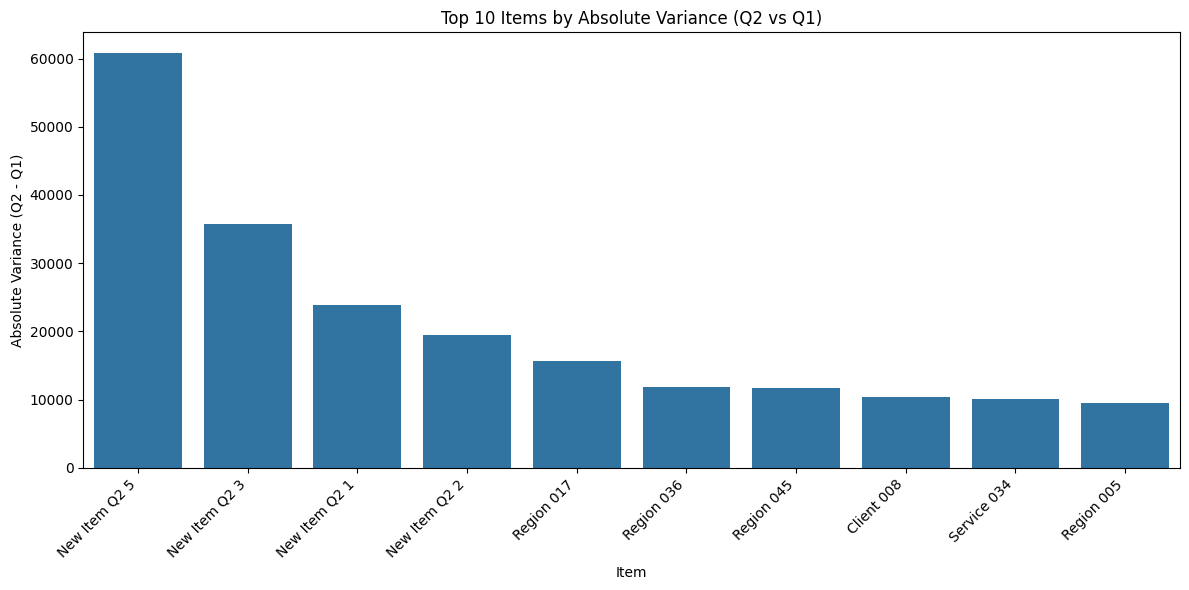

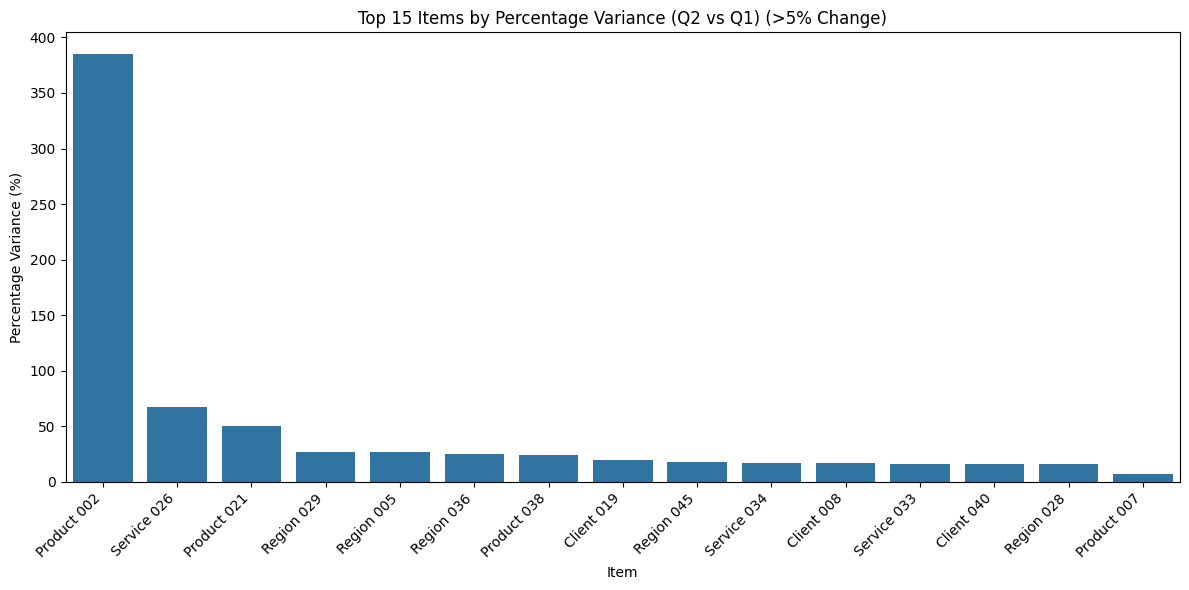

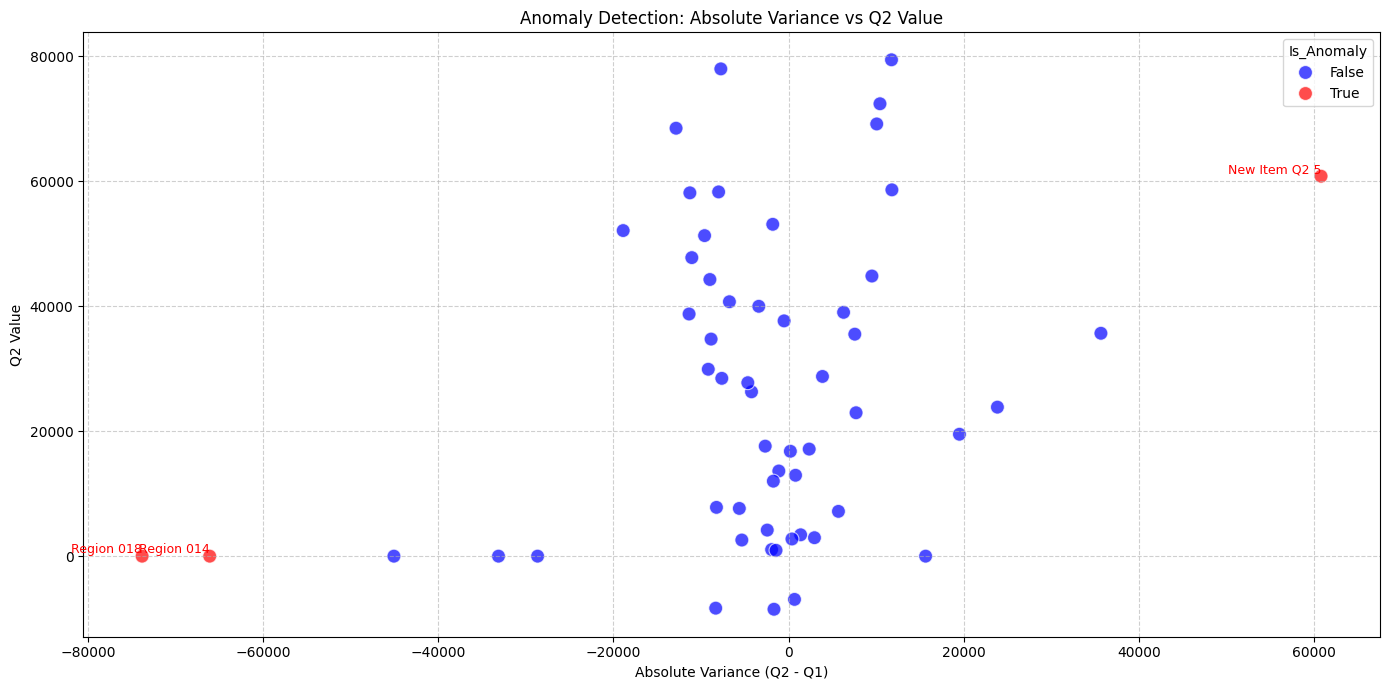

In [20]:
# Convert 'Percentage_Variance' to numeric where possible for plotting
df_merged_plot = df_merged.copy()
df_merged_plot['Percentage_Variance_Numeric'] = pd.to_numeric(df_merged_plot['Percentage_Variance'], errors='coerce')

# Plotting Absolute Variance
plt.figure(figsize=(12, 6))
sns.barplot(x=key_column, y='Absolute_Variance', data=df_merged_plot.sort_values(by='Absolute_Variance', ascending=False).head(10))
plt.title('Top 10 Items by Absolute Variance (Q2 vs Q1)')
plt.xlabel('Item')
plt.ylabel('Absolute Variance (Q2 - Q1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting Percentage Variance (excluding N/A and very small variances for clarity)
plt.figure(figsize=(12, 6))
sns.barplot(x=key_column, y='Percentage_Variance_Numeric',
            data=df_merged_plot[
                (df_merged_plot['Percentage_Variance_Numeric'].notna()) &
                (abs(df_merged_plot['Percentage_Variance_Numeric']) > 5) # Filter for >5% change
            ].sort_values(by='Percentage_Variance_Numeric', ascending=False).head(15))
plt.title('Top 15 Items by Percentage Variance (Q2 vs Q1) (>5% Change)')
plt.xlabel('Item')
plt.ylabel('Percentage Variance (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Visualize Anomalies (if detected)
if df_merged['Is_Anomaly'].any():
    plt.figure(figsize=(14, 7))
    sns.scatterplot(x='Absolute_Variance', y='Q2_Value', hue='Is_Anomaly', data=df_merged,
                    palette={True: 'red', False: 'blue'}, s=100, alpha=0.7)
    plt.title('Anomaly Detection: Absolute Variance vs Q2 Value')
    plt.xlabel('Absolute Variance (Q2 - Q1)')
    plt.ylabel('Q2 Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Annotate anomalies
    for index, row in df_merged[df_merged['Is_Anomaly'] == True].iterrows():
        plt.text(row['Absolute_Variance'], row['Q2_Value'], row[key_column],
                 fontsize=9, ha='right', va='bottom', color='red')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo anomalies detected to visualize.")

LLM for Narrative Generation: As mentioned, after you've identified anomalies with your Python script, you can feed those key data points to an LLM (e.g., via an API like Google's Gemini, OpenAI's GPT) and ask it to write a brief summary or explanation for each anomaly. This adds a "human-readable" layer of intelligence to your report.

Example Prompt for LLM: "Analyze the following financial data variance: Item 'Product X' had Q1 sales of $10,000 and Q2 sales of $25,000, resulting in a +150% absolute variance of $15,000. This item was flagged as an anomaly. Provide a concise explanation and potential business implications."

Root Cause Analysis (AI-assisted): If you have more granular data (e.g., transactional data for each item), you could build a more sophisticated ML model to predict why certain variances occurred (e.g., promotional activity, supply chain issues, new competitor). This is a much larger ML project.

This comprehensive approach using Python gives you maximum flexibility, reproducibility, and the power to go beyond standard Excel functionality to uncover deeper insights.